In [1]:
# Install library for reading JPK File
# %pip uninstall pyafmreader --yes
# %pip install git+https://github.com/jlopezalo/pyafmreader.git

In [2]:
# Install library for AFM data Rheology Analysis
%pip uninstall pyafmrheo --yes
%pip install git+https://github.com/jlopezalo/pyafmrheo.git

Found existing installation: pyafmrheo 0.0.1
Uninstalling pyafmrheo-0.0.1:
  Successfully uninstalled pyafmrheo-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmrheo.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-8cqlfgs3
  Running command git clone -q https://github.com/jlopezalo/pyafmrheo.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-8cqlfgs3
  Created wheel for pyafmrheo: filename=pyafmrheo-0.0.1-py3-none-any.whl size=32826 sha256=76cced46fa2bc94793822ebf4c96bf9e5bc19d4995a38fbbc8e9ee1665e5cb39
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-90q1cjp8/wheels/fb/66/18/3e93b45c845b0d7b83ded1e127a1c127820d070ce5b71dece4
Successfully built pyafmrheo
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import libraries we will need
import numpy as np
import matplotlib.pyplot as plt

# Get file reader from library
from pyafmreader import loadfile

# Get data analysis tools
from pyafmrheo.utils.force_curves import *
from pyafmrheo.models.hertz import HertzModel
from pyafmrheo.models.ting import TingModel

In [4]:
# Define global variables
file_path = '/Users/javierlopez/Documents/testingPyFM/map-data-2021.12.06-19.40.19.296.jpk-force-map'
# file_path = '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/20200903_Egel2.0_00023.spm'
# file_path = '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/20200904_Egel4-Z1.0_00025.spm'
# file_path = '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/08171528.0_00001.pfc'
# Shapes available: paraboloid, pyramid
indenter_shape = "paraboloid"
tip_parameter = 30 * 1e-9 # meters
# tip_parameter = 35 # degrees
# Poisson ratio
poisson_ratio = 0.5
# If None it will use the deflection sensitivity from the file
deflection_sensitivity = None # m/V
# If None it will use the spring constant from the file
spring_constant = None # N/m
# General plotting params
plt.rcParams["figure.figsize"] = (10,5)
v0t = 150e-6
v0r = 150e-6

In [5]:
file = loadfile(file_path)

In [6]:
filemetadata = file.filemetadata
print(filemetadata)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
closed_loop = filemetadata['z_closed_loop']
file_deflection_sensitivity = filemetadata['defl_sens_nmbyV'] #nm/V
file_spring_constant = filemetadata['spring_const_Nbym'] #N/m
height_channel = filemetadata['height_channel_key']

if not deflection_sensitivity: deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
if not spring_constant: spring_constant = file_spring_constant
    
print(file_spring_constant)
print(deflection_sensitivity)

0.135
7.469391092311744e-09


In [8]:
curve_idx = 0
force_curve = file.getcurve(curve_idx)
extend_segments = force_curve.extend_segments
pause_segments = force_curve.pause_segments
modulation_segments = force_curve.modulation_segments
retract_segments = force_curve.retract_segments
force_curve_segments = force_curve.get_segments()

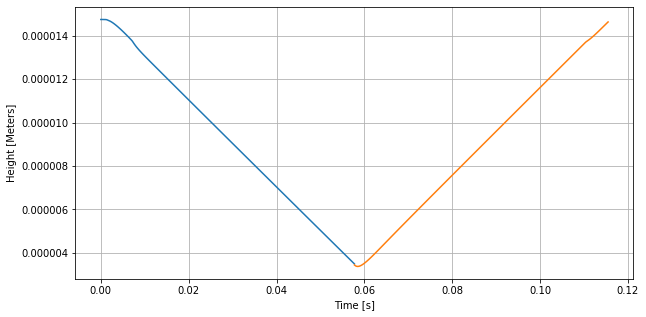

In [9]:
t0 = 0
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    if seg_id == '1':
         height = height[::-1]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, height)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Height [Meters]")
plt.grid()
plt.show()

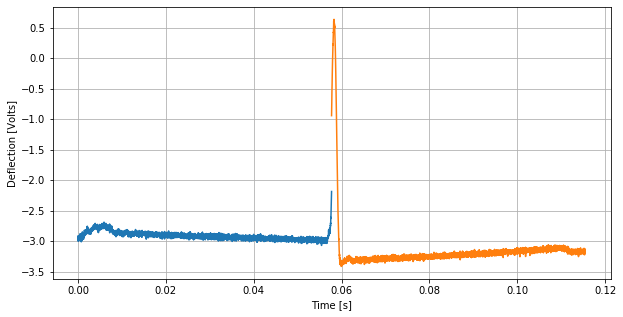

In [10]:
t0 = 0
for seg_id, segment in force_curve_segments:
    deflection = segment.segment_formated_data["vDeflection"]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, deflection)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Deflection [Volts]")
plt.grid()
plt.show()

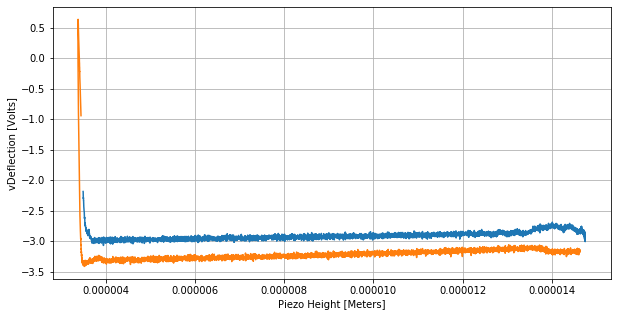

In [11]:
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    deflection = segment.segment_formated_data["vDeflection"]
    plt.plot(height, deflection)

plt.xlabel("Piezo Height [Meters]")
plt.ylabel("vDeflection [Volts]")
plt.grid()
plt.show()

In [12]:
force_curve.preprocess_force_curve(deflection_sensitivity, height_channel)

# Get approach, first extend segment
first_exted_seg_id, first_ext_seg = extend_segments[0]

# Get retract, last retract segment
last_ret_seg_id, last_ret_seg = retract_segments[-1]

In [13]:
# Shift height
force_curve.shift_height()

In [14]:
t_offset = np.abs(first_ext_seg.zheight[-1] - last_ret_seg.zheight[0]) / v0t
dt = np.abs(first_ext_seg.time[1] - first_ext_seg.time[0])
if t_offset > 2 * dt:
    last_ret_seg.time = last_ret_seg.time + t_offset

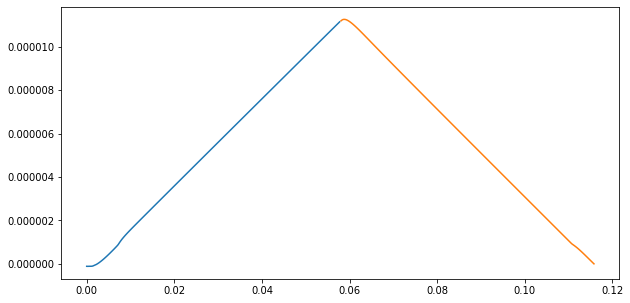

In [15]:
plt.plot(first_ext_seg.time, first_ext_seg.zheight)
plt.plot(last_ret_seg.time + first_ext_seg.time[-1], last_ret_seg.zheight)

In [16]:
app_height = first_ext_seg.zheight
app_deflection = first_ext_seg.vdeflection
ret_height = last_ret_seg.zheight
ret_deflection = last_ret_seg.vdeflection

In [17]:
# Find initial PoC, you may get some warnings.
poc = get_poc_RoV_method(app_height, app_deflection, win_size=50)
print(*poc)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1.093835277859725e-05 8.400562649599004e-11


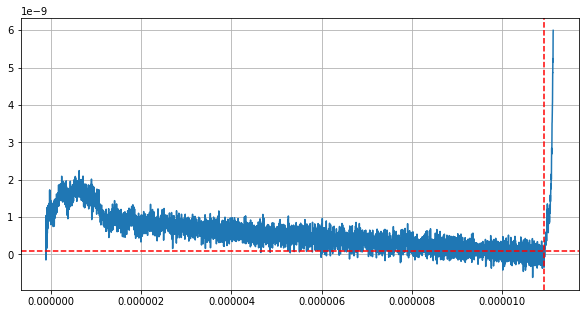

In [18]:
plt.plot(app_height, app_deflection)
plt.axvline(x=poc[0], color='r', linestyle='--')
plt.axhline(y=poc[1], color='r', linestyle='--')
plt.grid()
plt.show()

In [19]:
# plt.plot(app_height, app_deflection)
# mask = app_height<poc[0]
# plt.plot(app_height[mask], app_deflection[mask])
# z = np.poly1d(np.polyfit(app_height[mask], app_deflection[mask], 1))
# plt.plot(app_height[mask], z(app_height[mask]))

In [20]:
# plt.plot(app_height, app_deflection-z(app_height))
# plt.plot(ret_height, ret_deflection-z(ret_height))
# first_ext_seg.vdeflection = app_deflection-z(app_height)
# last_ret_seg.vdeflection = ret_deflection-z(ret_height)

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/lib/python3.8/site-packages/pyafmrheo/models/hertz.py:157: RuntimeWarning: divide by zero encountered in divide
  a = (self.get_residuals(indentation, force, sample_height)**2/force)



        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 3.0000000000000004e-08

        BEC Model: None

        Number of free parameters: 3

        delta0: 6.21905413149089e-08

        E0: 30957.945347277837

        f0: 6.359472688440074e-11

        slope: None

        # Fit metrics
        MAE: 4.584305438464996e-27

        MSE: 3.708021335501817e-21

        RMSE: 6.089352457775635e-11

        Rsq: 0.1793934758490231

        Chisq: -4.254765367761143e-07

        RedChisq: -1.4182551225870477e-07

        
30957.945347277837


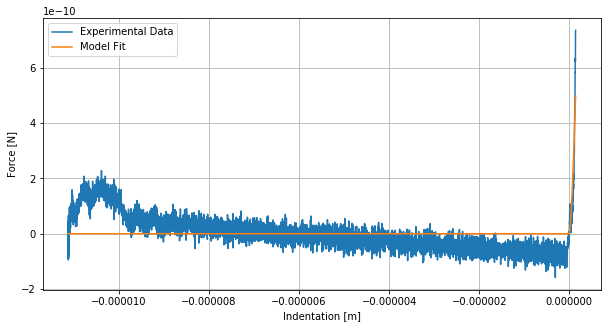

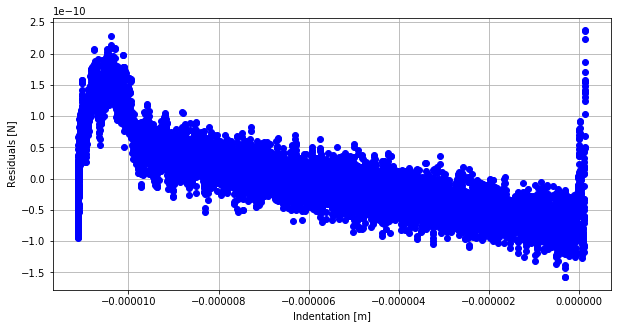

In [21]:
# Hertz fit
first_ext_seg.get_force_vs_indentation(poc, spring_constant)
app_indentation, app_force = first_ext_seg.indentation, first_ext_seg.force

# plt.plot(app_height - poc[0], app_deflection*spring_constant)
# plt.show()

# app_indentation = app_height - poc[0]
# app_force = app_deflection*spring_constant

hertzmodel = HertzModel(indenter_shape, tip_parameter)
hertzmodel.fit(app_indentation, app_force)

hertzmodel.fit_report()

hertz_E0 = hertzmodel.E0
hertz_d0 = hertzmodel.delta0
hertz_f0 = hertzmodel.f0

print(hertz_E0)

# Plot Hertz Fit results
plt.plot(app_indentation-hertz_d0, app_force-hertz_f0, label="Experimental Data")
plt.plot(app_indentation-hertz_d0, hertzmodel.eval(app_indentation)-hertz_f0, label="Model Fit")
plt.xlabel('Indentation [m]')
plt.ylabel('Force [N]')
plt.legend()
plt.grid()
plt.show()

# Plot residuals
plt.plot(app_indentation-hertz_d0, hertzmodel.get_residuals(app_indentation, app_force), "bo")
plt.xlabel('Indentation [m]')
plt.ylabel('Residuals [N]')
plt.grid()
plt.show()

In [22]:
# Get force vs indentation for all segments
poc[0] += hertz_d0

# Get indentation and force
first_ext_seg.get_force_vs_indentation(poc, spring_constant)
app_indentation, app_force, app_time = first_ext_seg.indentation, first_ext_seg.force, first_ext_seg.time
last_ret_seg.get_force_vs_indentation(poc, spring_constant)
ret_indentation, ret_force, ret_time = last_ret_seg.indentation, last_ret_seg.force, last_ret_seg.time

In [23]:
indentation = np.r_[app_indentation, ret_indentation]
idx_tc = (np.abs(app_indentation - 0)).argmin()
force = np.r_[app_force, ret_force]
t0 = app_time[-1]
time = np.r_[app_time, ret_time + t0]
tc = time[idx_tc]
fit_mask = indentation > (-1 * 1e-6)
ind_fit = indentation[fit_mask]
force_fit = force[fit_mask]
force_fit = force_fit - force_fit[0]
time_fit = time[fit_mask]
tc_fit = tc-time_fit[0]
time_fit = time_fit - time_fit[0]
tm = time_fit[np.argmax(force_fit)]
idx_tm = np.argmax(force_fit)

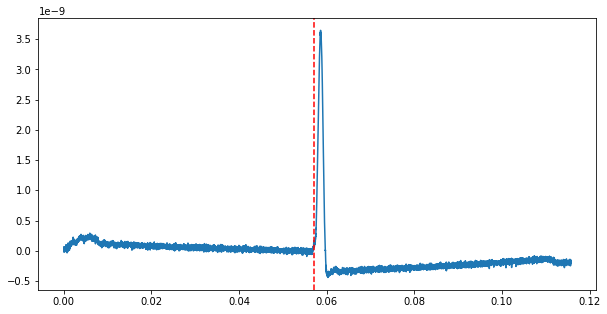

In [24]:
plt.plot(time, force)
plt.axvline(x=tc, color='r', linestyle='--')
plt.show()

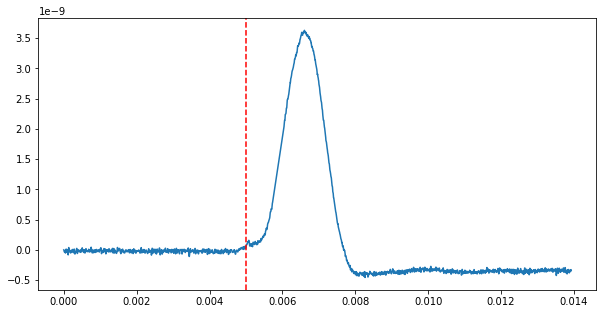

In [25]:
plt.plot(time_fit, force_fit)
plt.axvline(x=tc_fit, color='r', linestyle='--')
plt.show()

In [26]:
help(TingModel)

Help on class TingModel in module pyafmrheo.models.ting:

class TingModel(builtins.object)
 |  TingModel(ind_geom, tip_param, modelFt) -> None
 |  
 |  Methods defined here:
 |  
 |  SolveAnalytical(self, ttc, trc, t1, model_probe, geom_coeff, v0t, v0r, v0, E0, betaE, t0, F0, vdrag)
 |  
 |  SolveNumerical(self, delta, time_, geom_coeff, geom_exp, v0t, v0r, E0, betaE, F0, vdrag, smooth_w, idx_tm, idxCt, idxCr)
 |  
 |  __init__(self, ind_geom, tip_param, modelFt) -> None
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  eval(self, time, F, delta, t0, idx_tm=None, smooth_w=None, v0t=None, v0r=None)
 |  
 |  fit(self, time, F, delta, t0, idx_tm=None, smooth_w=None, v0t=None, v0r=None)
 |  
 |  fit_report(self)
 |  
 |  get_chisq(self, time, F, delta, t0, idx_tm=None, smooth_w=None, v0t=None, v0r=None)
 |  
 |  get_red_chisq(self, time, F, delta, t0, idx_tm=None, smooth_w=None, v0t=None, v0r=None)
 |  
 |  get_residuals(self, time, F, delta, t0, idx_tm=None, 

In [27]:
ting_model_num = TingModel(indenter_shape, tip_parameter, 'numerical')
ting_model_num.betaE_init = 0.2
ting_model_num.E0_init = hertz_E0
ting_model_num.tc_init = tc_fit
ting_model_num.fit(time_fit, force_fit, ind_fit, t0=1, idx_tm=idx_tm, smooth_w=5, v0t=v0t, v0r=v0r)
ting_model_num.fit_report()
tc_num = ting_model_num.tc
f0_num = ting_model_num.F0

/opt/anaconda3/lib/python3.8/site-packages/pyafmrheo/models/ting.py:80: RuntimeWarning: invalid value encountered in power
  A = smoothM(np.r_[numdiff(delta0[idxCt]**geom_exp), numdiff(delta0[idxCr[0]:]**geom_exp)], smooth_w)
/opt/anaconda3/lib/python3.8/site-packages/pyafmrheo/models/ting.py:228: RuntimeWarning: overflow encountered in double_scalars
  self.E0 = 10 ** res[0]
/opt/anaconda3/lib/python3.8/site-packages/pyafmrheo/models/ting.py:92: RuntimeWarning: invalid value encountered in double_scalars
  Ftc[i] = geom_coeff * E0 * np.sum(delta_Uto_dot[idx]*np.flipud(time_[idx])**(-betaE))
/opt/anaconda3/lib/python3.8/site-packages/pyafmrheo/models/ting.py:102: RuntimeWarning: invalid value encountered in double_scalars
  Frc[j-idx_tm-1] = geom_coeff * E0 * np.trapz(delta_Uto_dot[idx]*t10**(-betaE))
/opt/anaconda3/lib/python3.8/site-packages/pyafmrheo/models/ting.py:256: RuntimeWarning: invalid value encountered in divide
  a = (self.get_residuals(time, F, delta, t0, idx_tm, smooth_w


        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 3.0000000000000004e-08

        Model Format: numerical

        Viscous Drag: 0

        Smooth Window: 5

        t0: 1

        Maximum Indentation Time: 1259

        Number of free parameters: 4

        E0: inf

        tc: 0.0050050000000000025

        betaE: 1.5848931924611136

        F0: 0.0

        # Fit metrics
        MAE: nan

        MSE: nan

        RMSE: nan

        Rsq: nan

        Chisq: -4.486423657216344e-07

        RedChisq: -1.121605914304086e-07

        


In [28]:
ting_model_analit = TingModel(indenter_shape, tip_parameter, 'analytical')
ting_model_analit.betaE_init = 0.2
ting_model_analit.E0_init = hertz_E0
ting_model_analit.tc_init = tc_fit
ting_model_analit.fit(time_fit, force_fit, ind_fit, t0=1, idx_tm=idx_tm, smooth_w=5, v0t=v0t, v0r=v0r)
ting_model_analit.fit_report()
tc_analit = ting_model_analit.tc
f0_analit = ting_model_analit.F0


        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 3.0000000000000004e-08

        Model Format: analytical

        Viscous Drag: 0

        Smooth Window: 5

        t0: 1

        Maximum Indentation Time: 1259

        Number of free parameters: 4

        E0: inf

        tc: 0.0050050000000000025

        betaE: 1.5848931924611136

        F0: 0.0

        # Fit metrics
        MAE: -inf

        MSE: inf

        RMSE: inf

        Rsq: nan

        Chisq: -3.0650571523222687e-07

        RedChisq: -7.662642880805672e-08

        


/opt/anaconda3/lib/python3.8/site-packages/pyafmrheo/models/ting.py:57: RuntimeWarning: divide by zero encountered in power
  Ftp=3/2*v0t**(3/2)*E0*t0**betaE*np.sqrt(np.pi)*np.array(gamma(1-betaE), dtype=float)/(Cp*2*np.array(gamma(5/2-betaE), dtype=float))*ttc**(3/2-betaE)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


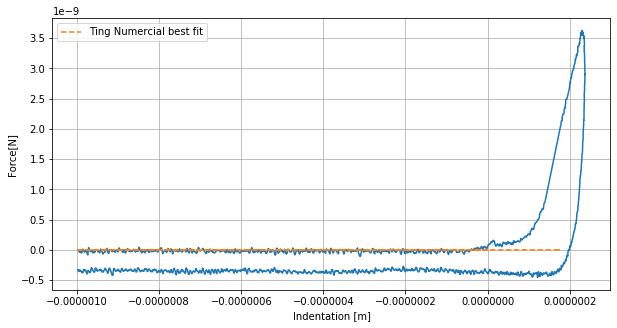

In [29]:
idx_tc = (np.abs(time_fit - tc_num)).argmin()
delta0 = ind_fit[idx_tc]
plt.plot(ind_fit-delta0, force_fit)
plt.plot(ind_fit-delta0, ting_model_num.eval(time_fit, force_fit, ind_fit, t0=t0, idx_tm=idx_tm, smooth_w=5), '--', label='Ting Numercial best fit')
plt.xlabel("Indentation [m]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

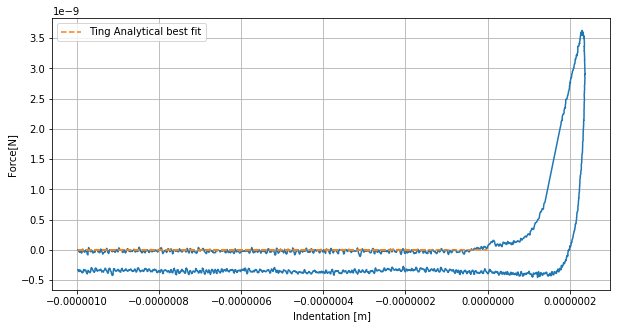

In [30]:
idx_tc = (np.abs(time_fit - tc_analit)).argmin()
delta0 = ind_fit[idx_tc]
plt.plot(ind_fit-delta0, force_fit)
plt.plot(ind_fit-delta0, ting_model_analit.eval(time_fit, force_fit, ind_fit, t0=t0, idx_tm=idx_tm, smooth_w=5), '--', label='Ting Analytical best fit')
plt.xlabel("Indentation [m]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

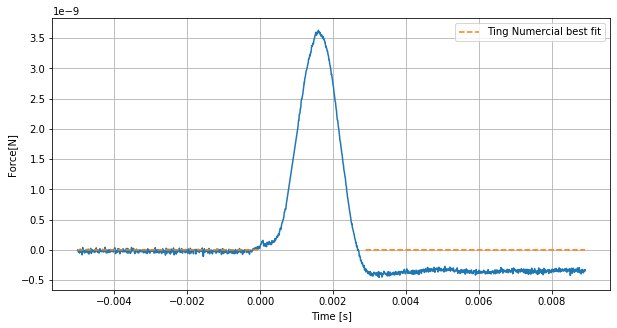

In [31]:
plt.plot(time_fit-tc_num, force_fit)
plt.plot(time_fit-tc_num, ting_model_num.eval(time_fit, force_fit, ind_fit, t0=t0, smooth_w=5), '--', label='Ting Numercial best fit')
plt.xlabel("Time [s]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

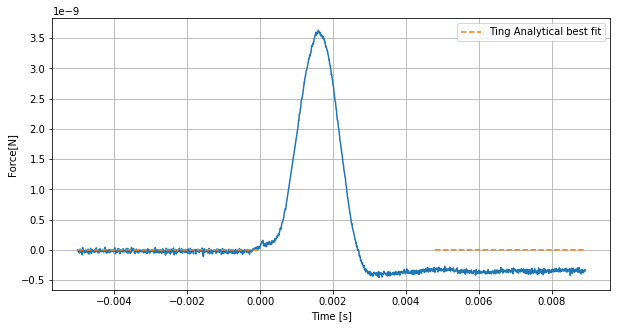

In [32]:
plt.plot(time_fit-tc_analit, force_fit)
plt.plot(time_fit-tc_analit, ting_model_analit.eval(time_fit, force_fit, ind_fit, t0=t0, smooth_w=5), '--', label='Ting Analytical best fit')
plt.xlabel("Time [s]")
plt.ylabel("Force[N]")
plt.legend()
plt.grid()
plt.show()

In [33]:
def get_AUC(indentation, force, idx_tm):
    # App
    app_ind = indentation[:idx_tm]
    app_forc = force[:idx_tm]
    auc_app = np.trapz(app_forc, app_ind)
    
    # Ret
    ret_ind = indentation[idx_tm:]
    ret_forc = force[idx_tm:]
    auc_ret = np.trapz(ret_forc, ret_ind)
    
    auc_tot = np.trapz(force, indentation)
    
    return auc_app, auc_ret, auc_tot

In [34]:
AUCApp, AUCRet, AUCTot = get_AUC(ind_fit, force_fit, idx_tm)
print(AUCApp, AUCRet, AUCTot)

2.1742605814106893e-16 4.1266261781964097e-16 6.297792587039143e-16


In [35]:
hertz_E0 * 1/(AUCApp-AUCRet)

-1.585663330589593e+20